In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings, datetime
warnings.filterwarnings('ignore')
%matplotlib inline

### Import and prepare data

In [66]:
data = pd.read_excel('E:/Sales.xlsx')

In [67]:
data.head()

,Billing Date,Customer,Material Number,Material Group,Qty,UoM,Net Value in Doc Currency
0,2019-06-02,10000003,100099,501,1920.0,KAR,1366867.14
1,2019-06-02,10000003,100101,503,1170.0,KAR,832934.68
2,2019-06-02,10000003,100107,504,690.0,KAR,491217.89
3,2019-06-02,10000003,100109,505,90.0,KAR,64071.90
4,2019-06-02,10000003,100105,503B,330.0,KAR,234930.30


In [68]:
data['Billing Date'] = pd.to_datetime(data['Billing Date'])

In [69]:
data.shape

(152773, 7)

In [70]:
data.drop(['Customer' , 'Material Number' , 'Material Group' , 'Qty' , 'UoM'] , axis = 1 , inplace = True)

In [71]:
data.columns = ['Date' , 'Sales']

In [72]:
# Merging data by dates
data['Date'] = data['Date'].apply(lambda x: str(x)[:-9])  
data = data.groupby('Date')['Sales'].sum().reset_index()
data.head()

,Date,Sales
0,2019-04-01,50648642.57
1,2019-04-02,49487702.60
2,2019-04-03,58869847.96
3,2019-04-04,61066072.85
4,2019-04-05,60422859.61


In [73]:
# Set index as date
data.set_index('Date', inplace= True)
data.dropna(inplace= True)
data.index = pd.to_datetime(data.index)

### ADF Test

In [74]:
from statsmodels.tsa.stattools import adfuller

In [75]:
def adf_check(time_series):
    print('\n------Dickey Fuller Test Results---------\n')
    result = adfuller(time_series)
    labels = ['ADF Test Statistic','p values','#Lags used','Number of Observations used']

    for value, label in zip(result, labels):
        print(label + ' : ' + str(value)+'\n')
    
    if result[1] <= 0.05:
        print('Since the evidence is strong enough we reject the null hypothesis so time series is stationary')
    else:
        print('Since the evidence is not enough we fail to reject the null hypothesis, so time series is not stationary')

In [76]:
adf_check(data['Sales'])


------Dickey Fuller Test Results---------

ADF Test Statistic : 0.3671719840476263

p values : 0.9802249013539144

#Lags used : 6

Number of Observations used : 84

Since the evidence is not enough we fail to reject the null hypothesis, so time series is not stationary


In [77]:
data['First Difference'] = data['Sales'] - data['Sales'].shift(1)

In [78]:
# By first Difference Data is Stationary
# So our d = 1
adf_check(data['First Difference'].dropna())


------Dickey Fuller Test Results---------

ADF Test Statistic : -8.688566234708064

p values : 4.0993982344005624e-14

#Lags used : 5

Number of Observations used : 84

Since the evidence is strong enough we reject the null hypothesis so time series is stationary


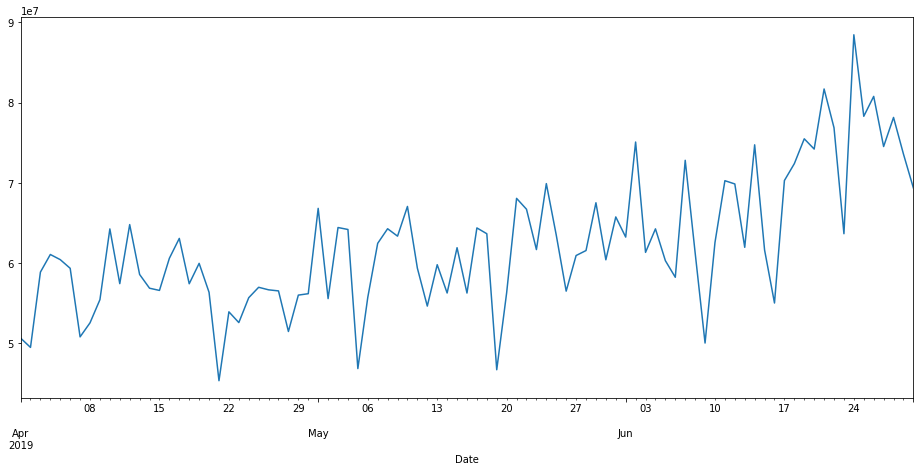

In [79]:
data['Sales'].plot(figsize = (16,7));

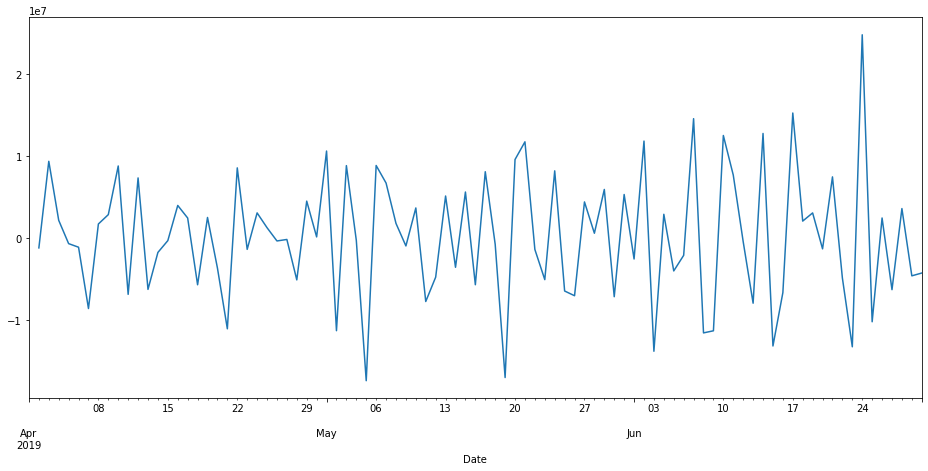

In [80]:
data['First Difference'].plot(figsize = (16,7));

In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

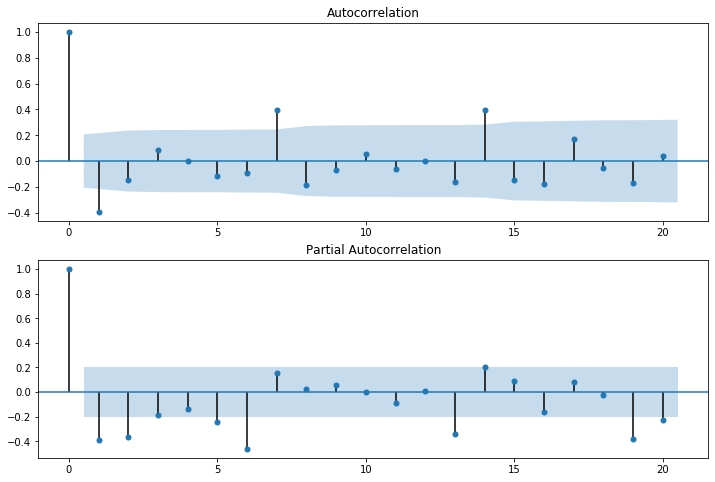

In [82]:
# Here pacf & acf Graph of First difference directly go to less than zero that suggests that we have over difference our series
# Thats why we need to take d = 0
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['First Difference'].dropna(), ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['First Difference'].dropna(), ax= ax2 , method = 'ols')

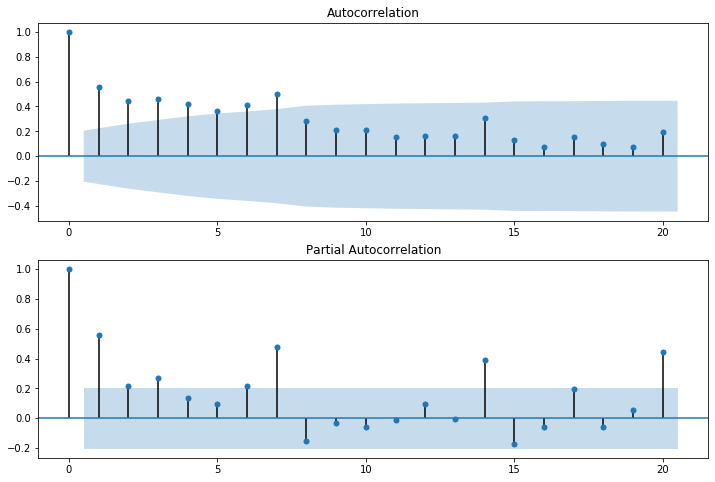

In [83]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Sales'].dropna(), ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Sales'].dropna(), ax= ax2 , method = 'ols')

### Model training and predictions

## Model - 1(Arima)(Sales pred)

In [84]:
from statsmodels.tsa.arima_model import ARIMA

In [85]:
data.dropna(inplace = True)

In [86]:
model=ARIMA(data['Sales'],order=(1,0,1))
model_fit=model.fit()

In [87]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   90
Model:                     ARMA(1, 1)   Log Likelihood               -1537.266
Method:                       css-mle   S.D. of innovations        6289160.334
Date:                Mon, 14 Jun 2021   AIC                           3082.531
Time:                        11:39:07   BIC                           3092.531
Sample:                    04-02-2019   HQIC                          3086.564
                         - 06-30-2019                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.242e+07   5.69e+06     10.973      0.000    5.13e+07    7.36e+07
ar.L1.Sales     0.9802      0.027     36.077      0.000       0.927       1.034
ma.L1.Sales    -0.7669      0.082     -9.325      0.000      -0.928      -0.606
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0202           +0.0000j            1.0202            0.0000
MA.1            1.3039           +0.0000j            1.3039            0.0000
-----------------------------------------------------------------------------
"""

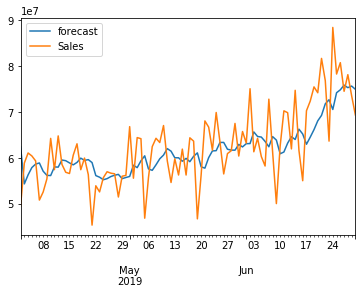

In [88]:
model_fit.plot_predict(dynamic=False)
plt.show()

## Model - 2(Sarimax)(Sales Pred)

In [89]:
model=sm.tsa.statespace.SARIMAX(data['Sales'],order=(1, 0, 1))
results=model.fit()

In [90]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   90
Model:                     ARMA(1, 1)   Log Likelihood               -1537.266
Method:                       css-mle   S.D. of innovations        6289160.334
Date:                Mon, 14 Jun 2021   AIC                           3082.531
Time:                        11:39:07   BIC                           3092.531
Sample:                    04-02-2019   HQIC                          3086.564
                         - 06-30-2019                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.242e+07   5.69e+06     10.973      0.000    5.13e+07    7.36e+07
ar.L1.Sales     0.9802      0.027     36.077      0.000       0.927       1.034
ma.L1.Sales    -0.7669      0.082     -9.325      0.000      -0.928      -0.606
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0202           +0.0000j            1.0202            0.0000
MA.1            1.3039           +0.0000j            1.3039            0.0000
-----------------------------------------------------------------------------
"""

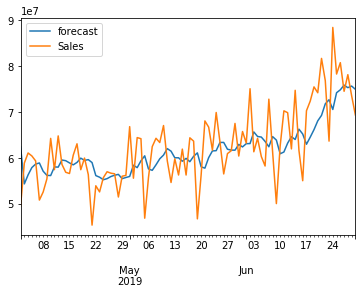

In [91]:
results.plot_predict(dynamic=False)
plt.show()

## Model - 3(Arima)(first diff. pred)

In [92]:
model=ARIMA(data['First Difference'],order=(1,0,1))
model_fit=model.fit()

In [93]:
# First difference can be calculated using SARIMAX model as it can predict data more precisely
# model=ARIMA(data['First Difference'],order=(1,1,1))
# model_fit=model.fit()

In [94]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       First Difference   No. Observations:                   90
Model:                     ARMA(1, 1)   Log Likelihood               -1534.958
Method:                       css-mle   S.D. of innovations        6127248.368
Date:                Mon, 14 Jun 2021   AIC                           3077.916
Time:                        11:39:08   BIC                           3087.915
Sample:                    04-02-2019   HQIC                          3081.948
                         - 06-30-2019                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2.079e+05   8.33e+04      2.497      0.014    4.47e+04    3.71e+05
ar.L1.First Difference     0.1417      0.130      1.094      0.277      -0.112       0.396
ma.L1.First Difference    -0.9014      0.069    -13.033      0.000      -1.037      -0.766
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            7.0548           +0.0000j            7.0548            0.0000
MA.1            1.1094           +0.0000j            1.1094            0.0000
-----------------------------------------------------------------------------
"""

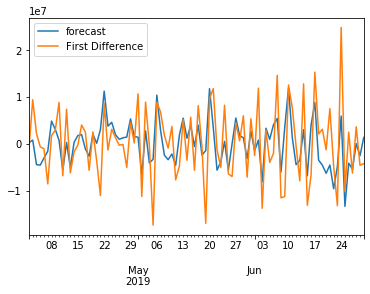

In [95]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [96]:
data.head(24)

,Sales,First Difference
Date,,
2019-04-02,49487702.60,-1160939.97
2019-04-03,58869847.96,9382145.36
2019-04-04,61066072.85,2196224.89
2019-04-05,60422859.61,-643213.24
2019-04-06,59344186.72,-1078672.89
2019-04-07,50799086.83,-8545099.89
2019-04-08,52548880.63,1749793.80
2019-04-09,55437508.62,2888627.99
2019-04-10,64251090.37,8813581.75


## Model - 4(Sarimax)(First diff pred)

In [97]:
# model=sm.tsa.statespace.SARIMAX(data['Sales'],order=(1, 0, 1))
model=sm.tsa.statespace.SARIMAX(data['First Difference'],order=(1, 0, 1))
results=model.fit()

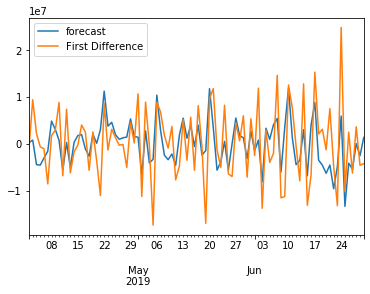

In [98]:
model_fit.plot_predict(dynamic=False)
plt.show()

## Model - 5 (Auto Arima)(Sales Pred)

In [105]:
import pmdarima as pm

In [109]:
model = pm.auto_arima(data['Sales'] , start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3086.216, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3489.864, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3431.034, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3087.436, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3087.009, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3419.265, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3087.481, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3091.243, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.644 seconds
